In [1]:
!pip install patchify
!pip install rasterio

In [1]:
import requests
from tqdm import tqdm
import sys
import pandas as pd
import numpy as np
from patchify import patchify
from pathlib import Path
import rasterio
from rasterio.enums import Resampling
import time

In [2]:
width = 256
height = 256
step = 400

patches_path = Path('E:/fyp/test/dataset/patches')
sources_path = Path('E:/fyp/test/dataset/sources')
dtm_path = sources_path / 'dtm'
gray_path = sources_path / 'gray'
no_files = 1


def download_file(url, filename, desc):
    try:
        chunk_size = 1024
        total = int(requests.head(url).headers["Content-Length"])
        with requests.get(url, stream=True) as r, open(filename, "wb") as f, tqdm(
                unit="B",  # unit string to be displayed.
                unit_scale=True,  # let tqdm to determine the scale in kilo, mega..etc.
                unit_divisor=1024,  # is used when unit_scale is true
                total=total,  # the total iteration.
                file=sys.stdout,  # default goes to stderr, this is the display on console.
                desc=desc  # prefix to be displayed on progress bar.
        ) as pbar:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if chunk:
                    datasize = f.write(chunk)
                    pbar.update(datasize)
            return True
    except:
        return False


def check_integrity(url, filename):
    with requests.get(url, stream=True) as r:
        content_length = int(requests.head(url).headers["Content-Length"])
        size_on_disk = int(filename.stat().st_size if filename.exists() else 0)
        if size_on_disk == content_length:
            return True
        else:
            return False


def start_downloads(url_list, filename_list):
    total = len(url_list)
    for i, (url, filename) in enumerate(zip(url_list, filename_list)):
        if not filename.exists():
            desc = f'{i + 1}/{total}'
            while not download_file(url, filename, desc):
                print(f'download from {url} failed, retrying...')
                time.sleep(10)
            time.sleep(10)

    print('Checking files integrity...')
    for i, (url, filename) in enumerate(zip(url_list, filename_list)):
        while not check_integrity(url, filename):
            print(f'{i + 1}/{total}: {filename.name} corrupted, downloading...')
            while not download_file(url, filename, ''):
                print(f'download from {url} failed, retrying...')
        print(f'{i + 1}/{total}: {filename.name} integer')
        
def save_patch(path, patch, nodata):  # data -> 3, 512, 512
    if not np.any(patch[1] == nodata):
        with rasterio.Env():
            with rasterio.open(path, 'w',
                               driver='GTiff',
                               count=2,
                               width=width,
                               height=height,
                               dtype=rasterio.float32) as dst:
                dst.write(patch.astype(rasterio.float32))
        return True
    else:
        return False


if __name__ == '__main__':
    dtm_path.mkdir(parents=True, exist_ok=True)
    gray_path.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv('sources.csv')

    url_list, filename_list = [], []
    for _, row in df.iterrows():
        name = row['dtm'].split('/')[-2]
        dtm_url, left_url, right_url = row['dtm'], row['left'], row['right']
        dtm_fn, left_fn, right_fn = dtm_path / f'{name}.IMG', gray_path / f'{name}_L.JP2', gray_path / f'{name}_R.JP2'
        url_list += [dtm_url, left_url]
        filename_list += [dtm_fn, left_fn]
    start_downloads(url_list[:2*no_files], filename_list[:2*no_files])
    print("Downloading completed\n")
    
    patches_path.mkdir(parents=True, exist_ok=True)
    resources = [str(x.name)[:-4] for x in dtm_path.iterdir() if x.is_file()]
    resources = [x for x in resources if not (patches_path / x).exists()]
    for i, resource in enumerate(resources):
        output_path = patches_path / resource
        print(f'Splitting {resource}')
        
        dtm_src = rasterio.open(dtm_path / (resource + '.IMG'))
        dtm, dtm_profile = dtm_src.read(1), dtm_src.profile

        out_shape = (1, dtm.shape[0], dtm.shape[1])
        resampling = Resampling.bilinear

        left_src = rasterio.open(gray_path / (resource + '_L.JP2'))
        print(dtm.shape)
        lft = left_src.read(1)
        print(lft.shape)
        left = left_src.read(1, out_shape=out_shape, resampling=resampling)

        right_src = rasterio.open(gray_path / (resource + '_R.JP2'))
        right = right_src.read(1, out_shape=out_shape, resampling=resampling)

        nodata = dtm_profile['nodata']

        stack = np.stack([left, dtm])

        patches = patchify(stack, (2, height, width), step=step)  # 1, rows, cols, 3, height, width
        patches = patches.reshape(patches.shape[1] * patches.shape[2], patches.shape[3], patches.shape[4], -1)

        num = patches.shape[0]
        print(f'{num} patches generated')

        print(output_path)
        output_path.mkdir(parents=True, exist_ok=True)
        for j in range(num):
            patch = patches[j]
            result = save_patch(output_path / f'patch_{j + 1}.tiff', patch, nodata)
            print(f"{i + 1}/{len(resources)}: patch {j + 1} {'saved' if result else 'discarded'}")
        


Checking files integrity...
1/2: ESP_011265_1560_ESP_011331_1560.IMG integer
2/2: ESP_011265_1560_ESP_011331_1560_L.JP2 integer

Splitting ESP_011265_1560_ESP_011331_1560
(18369, 7449)
(18369, 7449)
828 patches generated
E:\fyp\test\dataset\patches\ESP_011265_1560_ESP_011331_1560
1/1: patch 1 discarded
1/1: patch 2 discarded
1/1: patch 3 discarded
1/1: patch 4 discarded
1/1: patch 5 discarded
1/1: patch 6 discarded
1/1: patch 7 discarded
1/1: patch 8 discarded
1/1: patch 9 discarded
1/1: patch 10 discarded
1/1: patch 11 discarded
1/1: patch 12 discarded
1/1: patch 13 discarded
1/1: patch 14 discarded
1/1: patch 15 discarded
1/1: patch 16 discarded
1/1: patch 17 discarded
1/1: patch 18 discarded
1/1: patch 19 discarded
1/1: patch 20 discarded
1/1: patch 21 discarded
1/1: patch 22 discarded
1/1: patch 23 discarded
1/1: patch 24 saved
1/1: patch 25 saved
1/1: patch 26 saved
1/1: patch 27 saved
1/1: patch 28 saved
1/1: patch 29 saved
1/1: patch 30 saved
1/1: patch 31 saved
1/1: patch 32 di

C:\Users\malit\anaconda3\Lib\site-packages\rasterio\__init__.py:329: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


1/1: patch 39 saved
1/1: patch 40 saved
1/1: patch 41 saved
1/1: patch 42 saved
1/1: patch 43 saved
1/1: patch 44 saved
1/1: patch 45 saved
1/1: patch 46 saved
1/1: patch 47 saved
1/1: patch 48 saved
1/1: patch 49 saved
1/1: patch 50 discarded
1/1: patch 51 discarded
1/1: patch 52 discarded
1/1: patch 53 discarded
1/1: patch 54 discarded
1/1: patch 55 discarded
1/1: patch 56 saved
1/1: patch 57 saved
1/1: patch 58 saved
1/1: patch 59 saved
1/1: patch 60 saved
1/1: patch 61 saved
1/1: patch 62 saved
1/1: patch 63 saved
1/1: patch 64 saved
1/1: patch 65 saved
1/1: patch 66 saved
1/1: patch 67 saved
1/1: patch 68 discarded
1/1: patch 69 discarded
1/1: patch 70 discarded
1/1: patch 71 discarded
1/1: patch 72 discarded
1/1: patch 73 discarded
1/1: patch 74 saved
1/1: patch 75 saved
1/1: patch 76 saved
1/1: patch 77 saved
1/1: patch 78 saved
1/1: patch 79 saved
1/1: patch 80 saved
1/1: patch 81 saved
1/1: patch 82 saved
1/1: patch 83 saved
1/1: patch 84 saved
1/1: patch 85 saved
1/1: patch 8

1/1: patch 439 saved
1/1: patch 440 saved
1/1: patch 441 saved
1/1: patch 442 saved
1/1: patch 443 saved
1/1: patch 444 saved
1/1: patch 445 saved
1/1: patch 446 saved
1/1: patch 447 saved
1/1: patch 448 saved
1/1: patch 449 discarded
1/1: patch 450 discarded
1/1: patch 451 discarded
1/1: patch 452 discarded
1/1: patch 453 discarded
1/1: patch 454 discarded
1/1: patch 455 saved
1/1: patch 456 saved
1/1: patch 457 saved
1/1: patch 458 saved
1/1: patch 459 saved
1/1: patch 460 saved
1/1: patch 461 saved
1/1: patch 462 saved
1/1: patch 463 saved
1/1: patch 464 saved
1/1: patch 465 saved
1/1: patch 466 saved
1/1: patch 467 discarded
1/1: patch 468 discarded
1/1: patch 469 discarded
1/1: patch 470 discarded
1/1: patch 471 discarded
1/1: patch 472 discarded
1/1: patch 473 saved
1/1: patch 474 saved
1/1: patch 475 saved
1/1: patch 476 saved
1/1: patch 477 saved
1/1: patch 478 saved
1/1: patch 479 saved
1/1: patch 480 saved
1/1: patch 481 saved
1/1: patch 482 saved
1/1: patch 483 saved
1/1: pa

1/1: patch 809 saved
1/1: patch 810 discarded
1/1: patch 811 discarded
1/1: patch 812 discarded
1/1: patch 813 discarded
1/1: patch 814 discarded
1/1: patch 815 discarded
1/1: patch 816 discarded
1/1: patch 817 saved
1/1: patch 818 saved
1/1: patch 819 discarded
1/1: patch 820 discarded
1/1: patch 821 discarded
1/1: patch 822 discarded
1/1: patch 823 discarded
1/1: patch 824 discarded
1/1: patch 825 discarded
1/1: patch 826 discarded
1/1: patch 827 discarded
1/1: patch 828 discarded


In [3]:
from pathlib import Path
import rasterio
from torch.utils.data import Dataset
from torchvision import transforms
import random

In [15]:
class UAHiRISEDataset(Dataset):
    def __init__(self, root, stage, transform=None):
        self.root = Path(root)
        self.stage = stage
        self.transform = transform
        self.filenames = self._read_split()

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        print(filename)
        raster_path = self.root / filename

        raster = rasterio.open(raster_path)

        left = raster.read(1).astype('uint8')
        dtm = raster.read(2)

        # converting absolute heigths to relative depths
        dtm = abs(dtm - dtm.min())
        to_tensor = transforms.ToTensor()
        image = left

        if self.transform is not None:
            transformed = self.transform(image=image, mask=dtm)
            image = transformed['image']
            dtm = transformed['mask']

        image=to_tensor(image)
        dtm=to_tensor(dtm)

        return image, dtm

    def _read_split(self):
        split_filename = f'uahirise_{self.stage}.txt'
        split_filepath = Path.cwd() / 'filenames' / split_filename
        filenames = split_filepath.read_text().splitlines()
        return filenames

In [16]:
data = UAHiRISEDataset(patches_path,'sample')

In [17]:
data.filenames

['ESP_011265_1560_ESP_011331_1560/patch_25.tiff',
 'ESP_011265_1560_ESP_011331_1560/patch_26.tiff',
 'ESP_011265_1560_ESP_011331_1560/patch_27.tiff',
 'ESP_011265_1560_ESP_011331_1560/patch_28.tiff']

In [18]:
image, dtm = data.__getitem__(0)

ESP_011265_1560_ESP_011331_1560/patch_25.tiff


In [19]:
print(dtm)

tensor([[[1.7816e+01, 1.7803e+01, 1.7790e+01,  ..., 1.3412e+01,
          1.3447e+01, 1.3480e+01],
         [1.7786e+01, 1.7768e+01, 1.7751e+01,  ..., 1.3302e+01,
          1.3349e+01, 1.3393e+01],
         [1.7757e+01, 1.7738e+01, 1.7719e+01,  ..., 1.3177e+01,
          1.3221e+01, 1.3264e+01],
         ...,
         [1.6481e+00, 1.6091e+00, 1.5737e+00,  ..., 2.2681e-01,
          2.0374e-01, 1.8445e-01],
         [1.5587e+00, 1.5051e+00, 1.4611e+00,  ..., 1.2646e-01,
          1.0950e-01, 1.0583e-01],
         [1.4587e+00, 1.4178e+00, 1.3933e+00,  ..., 8.4229e-03,
          0.0000e+00, 1.1108e-02]]])


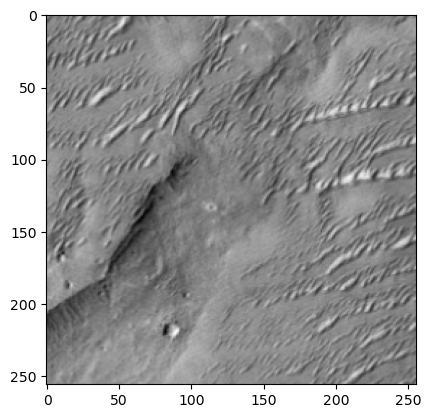

torch.Size([256, 256])

In [20]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
image_tensor = torch.squeeze(image)
plt.imshow(image_tensor, cmap='gray')  # Assuming it's a grayscale image
plt.show()
image_tensor.shape

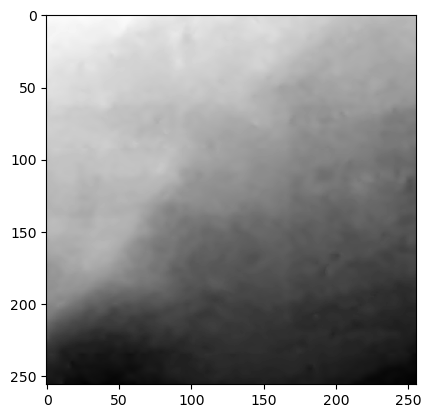

torch.Size([256, 256])

In [21]:
image_tensor = torch.squeeze(dtm)
plt.imshow(image_tensor, cmap='gray')  # Assuming it's a grayscale image
plt.show()
image_tensor.shape

torch.Size([256, 256])